In [1]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

rng = np.random.default_rng()

import matplotlib.pyplot as plt
from trajectories import *
from utils import *

import cvxpy as cp
from kalman_filter import *

T = 250 # how long to simulate the trajectory
# num_traj = num_traj_train + num_traj_test
num_traj = 10

(CVXPY) May 03 05:02:37 PM: Encountered unexpected exception importing solver SCS:
ImportError('dlopen(/Users/sagarasanghavi/.pyenv/versions/3.7.7/lib/python3.7/site-packages/_scs_direct.cpython-37m-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: /Users/sagarasanghavi/.pyenv/versions/3.7.7/lib/python3.7/site-packages/scs/.dylibs/libgomp.1.dylib (which was built for Mac OS X 10.15)\n  Expected in: /usr/lib/libSystem.B.dylib\n in /Users/sagarasanghavi/.pyenv/versions/3.7.7/lib/python3.7/site-packages/scs/.dylibs/libgomp.1.dylib')


Trajectory shape (250, 2)
Measured shape (250, 2)
Recovered by LS shape (250, 2)


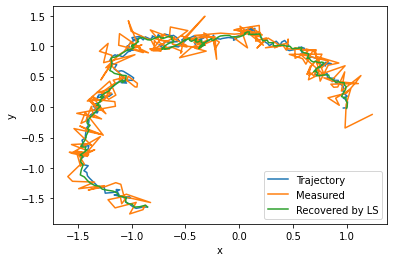

Average Error for LS Opt with CVX: 0.0024052162300528274


In [4]:
task_name = 'circular'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)

myMeas = meas[0]
myUseq = u_seq[0]
myTraj = traj[0]

xf = myTraj[-1]

ls_rec = optimal_traj(A, B, C, Q, R, myMeas, x0, xf, myUseq)

err_opt = np.linalg.norm(ls_rec - myTraj)**2

plot({"Trajectory": myTraj, "Measured": myMeas, "Recovered by LS":ls_rec})
print('Average Error for LS Opt with CVX:', err_opt / T)

## Minimum energy noise Optimization Using CVX. Compare to Forward-Backward Kalman Smoothing

In [ ]:
err_opt, err_kf_fwd, err_kf_bkwd, err_kf_smoothed = 0, 0, 0, 0

# plot a sample trajectory and noisy measurements
for i in range(num_traj):
    myTraj = traj[i]
    myMeas = meas[i]
    myUseq = u_seq[i]
    
    # Least Squares Optimization with CVX: Minimum Energy Noise
    xs = cp.Variable((T-1, state_dim))
    cost = obj_func(xs, myMeas, myUseq, x0, myTraj[-1], A, B, C)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    ls_rec = xs.value
    err_opt += np.linalg.norm(ls_rec - myTraj[:-1])**2
    
    # Kalman Filter Forward
    kinematics_forward = KFilter(A, B, C, Q, R, state=x0)
    fltr_fwd = kinematics_forward.simulate(myMeas, myUseq)
    err_kf_fwd += np.linalg.norm(fltr_fwd - myTraj)**2
    
    # Kalman Filter Backward
    kinematics_backward = KFilter(np.linalg.inv(A), -np.linalg.inv(A) @ B, C, Q, R, state=myTraj[-1])
    fltr_bkwd = np.flip(kinematics_backward.simulate(myMeas[::-1, :]), axis=0)
    err_kf_bkwd += np.linalg.norm(fltr_bkwd - myTraj)**2
    
    # Kalman Smoothed (Avg forward and backward)
    smooth_states = (fltr_fwd + fltr_bkwd) / 2
    err_kf_smoothed += np.linalg.norm(smooth_states - myTraj)**2
    
    # Some plots
#     plot({"Trajectory": myTraj, "Measured": myMeas, "Recovered by LS":ls_rec, "Forward Kalman Filtered":fltr_fwd, 
#           "Backward Kalman Filtered":fltr_bkwd, "Smoothed":smooth_states})
    
print('Average Error for LS Opt with CVX:', err_opt / T / num_traj)
print('Average Error for KF Forward:', err_kf_fwd / T / num_traj)
print('Average Error for KF Backward:', err_kf_bkwd / T / num_traj)
print('Average Error for KF Smoothed:', err_kf_smoothed / T / num_traj)